In [29]:
# !pip install datasets transformers
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import torch
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel

In [2]:
DATASET_NAME = "pcuenq/oxford-pets"
MODEL_NAME = "openai/clip-vit-base-patch32"
EMBEDDING_FILE_PATH = "oxford_pets_embeddings.npy"

In [4]:
dataset = load_dataset(DATASET_NAME, cache_dir=".")

Found cached dataset parquet (/root/developer/image-search-engine/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME)

2023-05-30 15:02:04.469720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-30 15:02:04.469768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
def embed_image(images):
    if not isinstance(images, list): images = [images]
    inputs = processor(images=images, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_image_features(**inputs)

In [7]:
def embed_text(text):
    inputs = processor(text=text, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_text_features(**inputs)

In [8]:
def get_image_embeddings(images, embdding_file_path):
    if embdding_file_path.exists():
        print("Loading")
        all_image_embs = torch.tensor(np.load(embdding_file_path))
    else:
        print("Converting")
        all_image_embs_raw = [embed_image(row) for row in tqdm(images)]
        np_embs = np.concatenate(list(map(lambda x: x.numpy(), all_image_embs_raw)))
        all_image_embs = torch.tensor(np_embs)
        np.save(embdding_file_path, np_embs)
    return all_image_embs

In [24]:
def search(image_embs, query_embs):
    sims = torch.nn.functional.cosine_similarity(image_embs, query_embs)
    indices = sims.argsort(descending=True)
    return indices, sims[indices]

In [25]:
def search_and_display(image_embs, query, k=5):
    indices, sims = search(image_embs, embed_text(query))
    for i in indices[:k]:
        image = dataset["train"][i.item()]["image"]
        display(image)

In [26]:
images = dataset["train"]["image"]

In [27]:
embeds = get_image_embeddings(images, Path(EMBEDDING_FILE_PATH))

Loading


In [28]:
embeds.shape

torch.Size([7390, 512])

tensor([0.2262, 0.2623, 0.2242,  ..., 0.1498, 0.1957, 0.1908])
tensor([4783, 3654, 4067,  ..., 6917, 2626, 6211])


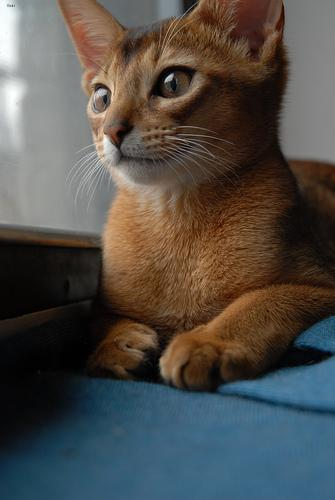

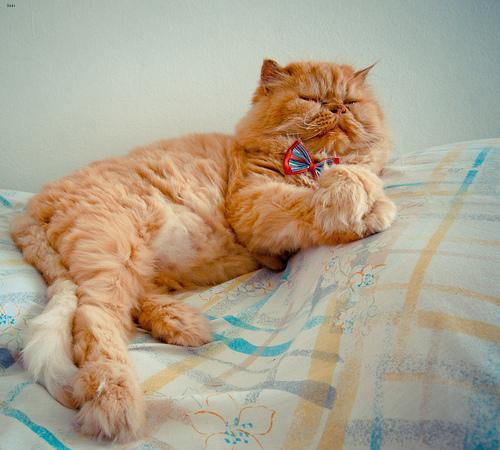

In [23]:
search_and_display(embeds, "an orange cat", k=2)